In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib
import pylab as pl
matplotlib.style.use('ggplot')
import seaborn as sns

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn import ensemble, metrics 
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans2

import warnings
warnings.filterwarnings('ignore')

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Функции Blending'а результатов предсказания анcамбля моделей и функция Gini

In [2]:
def blend_predictions(preds):
    step=0.1 * (1./len(preds))
    poidsref=np.zeros(len(preds))
    poids=np.zeros(len(preds))
    poidsreftemp=np.zeros(len(preds))
    poidsref=poidsref+1./len(preds)

    bestpoids=poidsref.copy()
    blend_cv=np.zeros(len(preds[0]))
    
    for k in range(0,len(preds),1):
        blend_cv=blend_cv+bestpoids[k]*preds[k]
        bestscore=metrics.log_loss(Ytarget,blend_cv)

    getting_better_score=True
    while getting_better_score:
        getting_better_score=False
        for i in range(0,len(preds),1):
            poids=poidsref
            if poids[i]-step>-step:
                poids[i]-=step
                for j in range(0,len(preds),1):
                    if j!=i:
                        if poids[j]+step<=1:
                            poids[j]+=step
                            blend_cv=np.zeros(len(preds[0]))
                            for k in range(0,len(preds),1):
                                blend_cv=blend_cv+poids[k]*preds[k]
                            actualscore=metrics.log_loss(Ytarget,blend_cv)
                            if actualscore<bestscore:
                                bestscore=actualscore
                                bestpoids=poids.copy()
                                getting_better_score=True
                            poids[j]-=step
                poids[i]+=step
        poidsref=bestpoids.copy()
    return bestpoids, predstest


def Gini(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    return G_pred/G_true

In [3]:
df=pd.read_csv('./germancredit.csv')

Базовая визуавлизация 

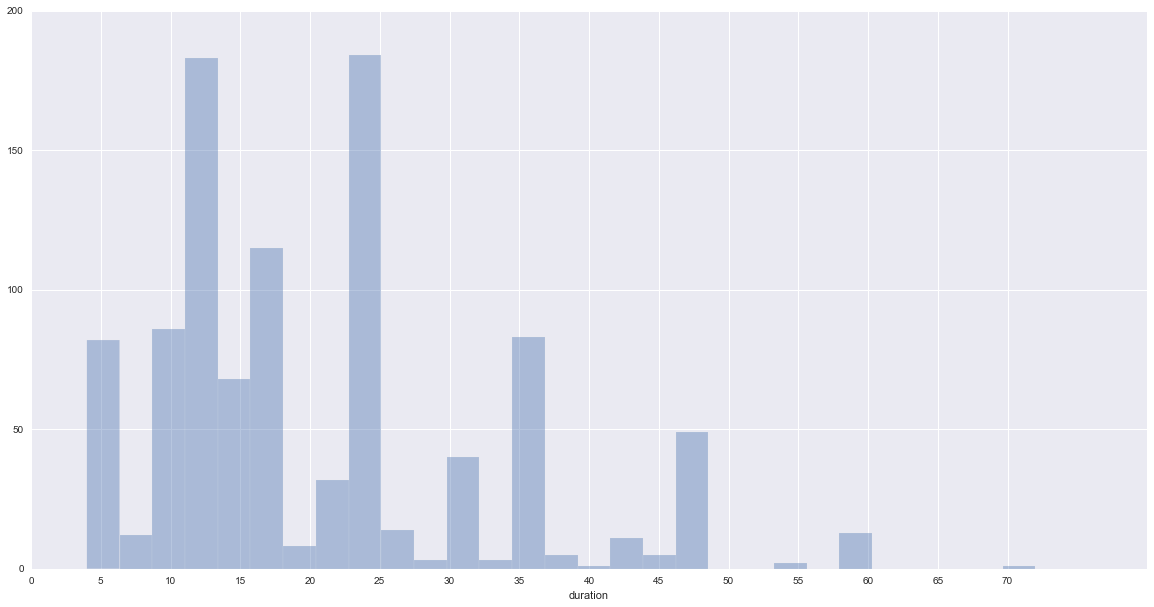

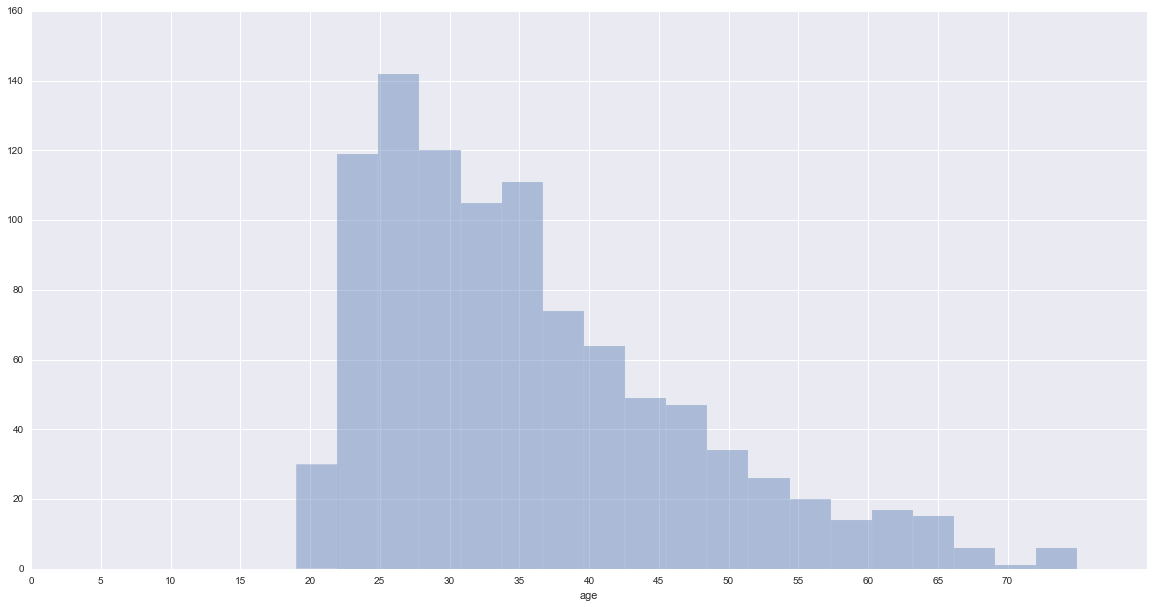

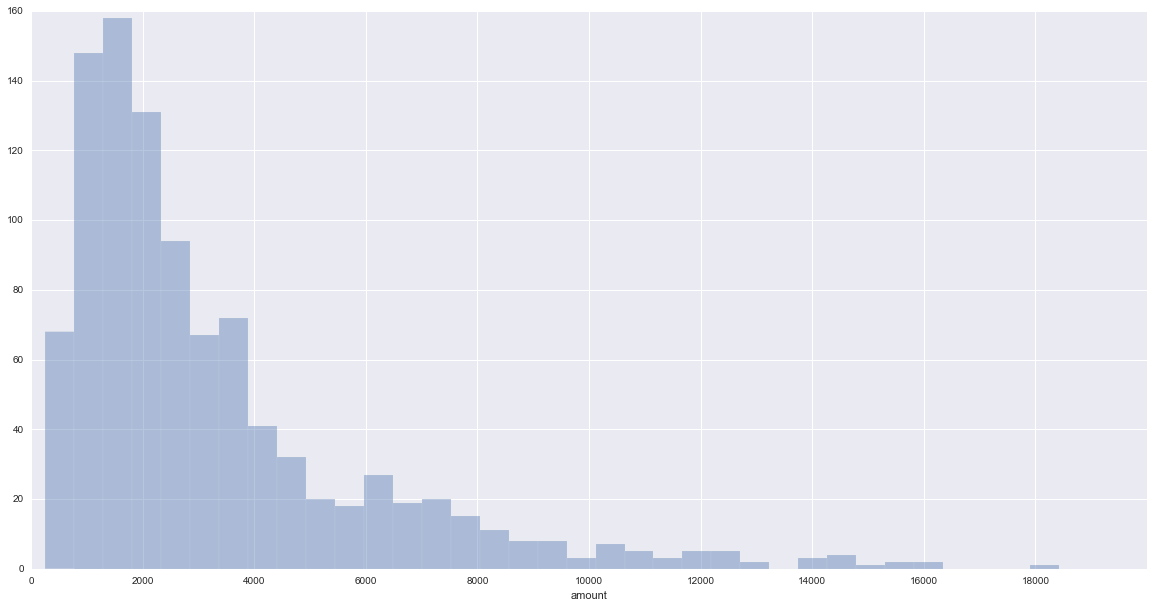

In [4]:
plt.figure(figsize=(20,10))
sns.distplot(df['duration'], kde=False, rug=False)
plt.xticks([s for s in range(0,df['duration'].max()) if s %5==0])

plt.figure(figsize=(20,10))
sns.distplot(df['age'], kde=False, rug=False)
plt.xticks([s for s in range(0,df['age'].max()) if s %5==0])

plt.figure(figsize=(20,10))
sns.distplot(df['amount'], kde=False, rug=False)
plt.xticks([s for s in range(0,df['amount'].max()) if s %2000==0])

plt.show();

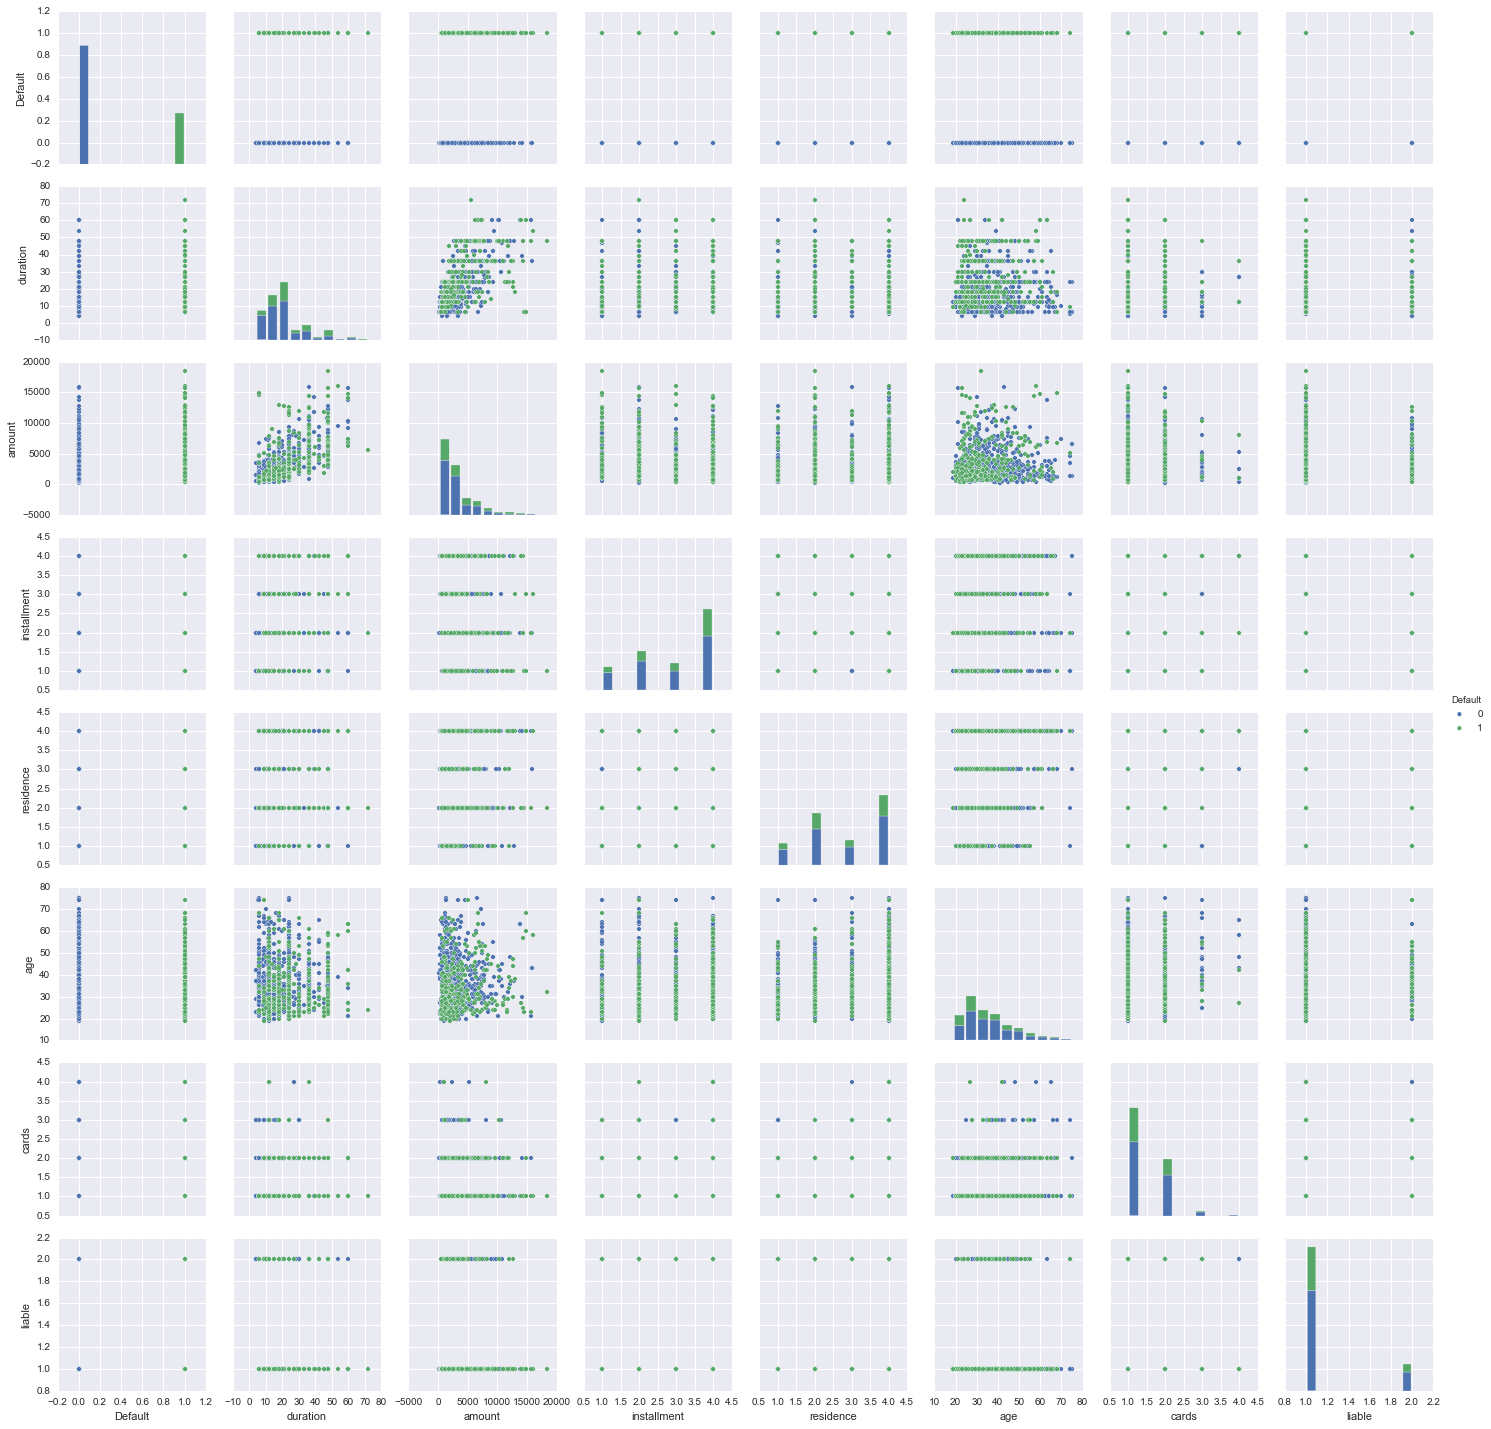

In [5]:
sns.pairplot(df, hue="Default")
plt.show()

Пример того, как были получены координты центров для KMeans.<br>
Подобным образом выбирал центры в которых корреляция с переменной Default выше  

**Процессинг данных:**
* заранее определены центы кластеров для кластерного анализа и введения новых переменных ('amount_cluster','age_cluster','duration_cluster','age_amount_duration_cluster')
* для кластерного анализаца использовался scipy.cluster.vq.kmeans2 т.к. в нем есть возможность заранее указать центы кластеров 
* определены списки num и obj которые используются далее в цикле для обработки данных 
* в цикле сразу обрабатываются категориальные переменные - 1. установка веса данной переменной(новые переменные имеют окончания weight), 2. используя LabelEncoder текст декодируется в число
* если переменная ичзначально была типа integer, то к ней применялся StandartScaler()


In [6]:
amount_centers= [1884.7988980716168, 5724.500000000012, 11695.589285714297]
age_centers= [26.937984496124074, 57.35251798561154, 39.63478260869562]
duration_centers=[10.711316397228705, 42.31213872832378, 22.70304568527918]
age_amount_duration_centers = np.array([[35.33972602739727, 1895.402739726019, 16.72602739726034],
                                         [36.11682242990654, 5760.098130841134, 30.24299065420559],
                                         [36.05357142857143, 11695.589285714297, 39.66071428571428]])

df['amount_cluster']=kmeans2(df['amount'].astype(float), minit='matrix', k=amount_centers)[1]
df['age_cluster']=kmeans2(df['age'].astype(float), minit='matrix', k=age_centers)[1]
df['duration_cluster']=kmeans2(df['duration'].astype(float), minit='matrix', k=age_centers)[1]
df['age_amount_duration_cluster'] = kmeans2(df[['age','amount','duration']].astype(np.float),minit='matrix',
                                            k=age_amount_duration_centers)[1]

label = LabelEncoder()
scaler = StandardScaler()
dicts = {}

num = [s[0] for s in df.dtypes.items() if 'int' in str(s[1]) and str(s[0]) not in ['Default','amount_cluster',
                                                                                   'age_cluster','duration_cluster',
                                                                                  'age_amount_duration_cluster'] ]
obj= [s[0] for s in df.dtypes.items() if 'obj' in str(s[1])  ]
target=df['Default']
for k,v in df.dtypes.items():
    vector=df[k]
    if k in obj :
        list2keep=vector.value_counts()[:10].index
        df[k]=df[k].apply(lambda x: x if x in list2keep else np.nan)
        tempTable=pd.concat([df[k], target], axis=1)
        tempTable=tempTable.groupby(by=k, axis=0).agg(['sum','count'])['Default']
        tempTable['weight']=tempTable.apply(lambda x: .5+.5*x['sum']/x['count'] if (x['sum']>x['count']-x['sum']) else .5+.5*(x['sum']-x['count'])/x['count'], axis=1)
        tempTable.reset_index(inplace=True)
        df[k+'_weight']=pd.merge(df, tempTable, how='left', on=k)['weight']
        df[k+'_weight']=df[k+'_weight'].fillna(.5)
        
        label.fit(df[k].drop_duplicates())
        dicts[k] = list(label.classes_)
        df[k] = label.transform(df[k])
    if k in num :
        scaler = StandardScaler().fit(df[k])
        df[k]= scaler.transform(df[k])

df.head(5)

Default  checkingstatus1  duration  history  purpose    amount  savings  \
0        0                0 -1.236478        4        4 -0.745131        4   
1        1                1  2.248194        2        4  0.949817        0   
2        0                3 -0.738668        4        7 -0.416562        0   
3        0                0  1.750384        2        3  1.634247        0   
4        1                0  0.256953        3        0  0.566664        0   

   employ  installment  status       ...        savings_weight  employ_weight  \
0       4     0.918477       2       ...              0.087432       0.126482   
1       2    -0.870183       1       ...              0.179934       0.153392   
2       3    -0.870183       2       ...              0.179934       0.112069   
3       3    -0.870183       2       ...              0.179934       0.112069   
4       2     0.024147       2       ...              0.179934       0.153392   

   status_weight  others_weight  property_weight  otherplans_weight  \
0       0.133212       0.149945         0.106383           0.137592   
1       0.175806       0.149945         0.106383           0.137592   
2       0.133212       0.149945         0.106383           0.137592   
3       0.133212       0.096154         0.153017           0.137592   
4       0.133212       0.149945         0.217532           0.137592   

   housing_weight  job_weight  tele_weight  foreign_weight  
0        0.130435    0.147619     0.139851        0.153686  
1        0.130435    0.147619     0.156879        0.153686  
2        0.130435    0.140000     0.156879        0.153686  
3        0.203704    0.147619     0.156879        0.153686  
4        0.203704    0.147619     0.156879        0.153686  

[5 rows x 38 columns]

Для тестирования модели был выбран метод разбиения на тестовую и тренеровочную выборки train_test_split<br>
В ансамль вошли следующие модели:
* 'RandomForest'
* 'ExtraTrees'
* 'GradientBoosting'
* 'Bagging

In [7]:
X, Y, Xtarget, Ytarget = train_test_split(df.drop(['Default'], axis=1),
                                          df['Default'], test_size=0.2, random_state=42)

clfs =[ 
    ensemble.RandomForestClassifier(bootstrap=False, class_weight={1:0.2, 0:0.8}, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=4, 
            min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=6,
            oob_score=False, random_state=42, verbose=0,
            warm_start=False),
    
    ensemble.ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features='sqrt', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=1e-5, n_estimators=450, n_jobs=6,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
    
    ensemble.GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=350,
              presort='auto', random_state=42, subsample=0.8, verbose=0,
              warm_start=False),
    ensemble.BaggingClassifier(DecisionTreeClassifier(max_depth =5, 
                                                       random_state=0),
                                                  n_jobs=6, random_state =42, n_estimators= 350)]

model_names = ['RandomForest','ExtraTrees','GradientBoosting', 'Bagging', 'Ensemble']

Вывод метрик качества: gini, auc, log_loss по каждой моделе<br>
Вывод Log_loss исходя с Blending'а<br>
Визуализация ROC кривых<br>


RandomForest: AUC = 0.807, Gini = 0.614, Loss = 0.476
ExtraTrees: AUC = 0.821, Gini = 0.642, Loss = 0.467
GradientBoosting: AUC = 0.802, Gini = 0.604, Loss = 0.489
Bagging: AUC = 0.809, Gini = 0.618, Loss = 0.476
Ensemble: AUC = 0.825, Gini = 0.649, Loss = 0.459


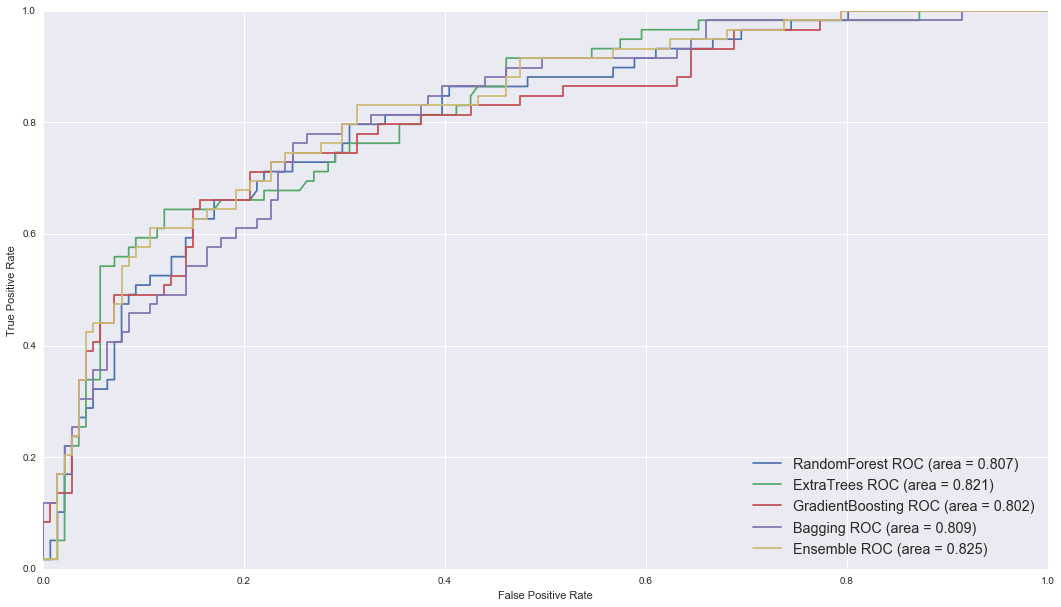

In [8]:
pl.clf()
plt.figure(figsize=(18,10))

indice=0
preds=[]
predstest=[]


for num, model in enumerate(clfs):
    model.fit(X, Xtarget)
    probas= model.predict_proba(Y)
    preds.append(probas[:,1])
    fpr, tpr, thresholds = metrics.roc_curve(Ytarget,probas[:,1])
    roc_auc =metrics.roc_auc_score(Ytarget,preds[indice])
    pl.plot(fpr,tpr, label='%s ROC (area = %0.3f)' % (model_names[num], roc_auc))
    print("%s: AUC = %0.3f, Gini = %0.3f, Loss = %0.3f"%(model_names[num],
                                                            roc_auc,
                                                            Gini(Ytarget,preds[indice]),
                                                            metrics.log_loss(Ytarget,preds[indice])))
    indice+=1

bestpoids, predstest =  blend_predictions(preds)
blend_preds=np.zeros(len(preds[0]))

for i in range(0,len(preds),1):
    blend_preds=blend_preds+bestpoids[i]*preds[i]

roc_auc =metrics.roc_auc_score(Ytarget,blend_preds)
fpr, tpr, thresholds = metrics.roc_curve(Ytarget,blend_preds)
pl.plot(fpr,tpr, label='%s ROC (area = %0.3f)' % (model_names[num+1], roc_auc))

print("%s: AUC = %0.3f, Gini = %0.3f, Loss = %0.3f"%(model_names[num+1],
                                                            roc_auc,
                                                            Gini(Ytarget,blend_preds),
                                                            metrics.log_loss(Ytarget,blend_preds)))

pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='large')
pl.show()

Как итог, сведенный прогноз по всем 3 выбраным метрикам выше 